In [373]:
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (confusion_matrix, classification_report, precision_recall_fscore_support,
                             roc_auc_score, roc_curve, log_loss, auc)
from sklearn.multiclass import OneVsRestClassifier

##plotting
from plotly.offline import init_notebook_mode, iplot, download_plotlyjs
import plotly.offline as pyo
import cufflinks as cf
import matplotlib.pyplot as plt
init_notebook_mode(connected=True)
cf.go_offline()

In [97]:
iris = load_iris()

In [98]:
df = pd.DataFrame(np.concatenate((iris.data.reshape(-1,4),iris.target.reshape(-1,1)),axis=1))
df.columns =[feature[:-5] for feature in iris.feature_names]+['target']

In [99]:
df['target'] = df.target.apply(lambda x: iris['target_names'][int(x)])
# df.drop(target,axis=1,inplace=True)

In [100]:
pyo.iplot(
    {
        'data': [
            {
                'x': df[df['target']==label]['petal width'],
                'y': df[df['target']==label]['petal length'],
                'name': label, 'mode': 'markers',
            } for label in iris.target_names
        ],
        'layout': {
            'xaxis': {'title': 'petal width'},
            'yaxis': {'title': "petal length"}
        }
})

In [101]:
df = pd.get_dummies(df)

In [104]:
target = [col for col in df.columns if col.startswith('target')]
variables = list(set(df.columns) - set([col for col in df.columns if col.startswith('target')]))

In [385]:
X_train, X_test, y_train, y_test = train_test_split(df[variables],df[target],test_size=0.2,random_state=42)
rf = RandomForestClassifier(random_state=42, max_depth=4, n_estimators=10, min_samples_leaf=3)
rf.fit(X_train,y_train)
nb = OneVsRestClassifier(GaussianNB())
nb.fit(X_train,y_train)
svm = OneVsRestClassifier(SVC(random_state=42,probability=True,kernel='linear',gamma='auto'))
svm.fit(X_train,y_train)

OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=None)

In [386]:
def multi_label_confusion_matrix(X, y, clf):
    zipped = np.dstack((y.values, clf.predict(X)))
#     else:
#         lr_pred = np.zeros_like(y)
#         for ind,col_ind in enumerate(np.argmax(clf.predict_proba(X),axis=1)):
#             lr_pred[ind, col_ind] = 1
#         zipped = np.dstack((y.values, lr_pred))
    conf_matrix = np.zeros([y.shape[1],y.shape[1]])
    for rows in zipped:
        if len(np.where(rows[:,1]==1)[0])>0:
            conf_matrix[np.where(rows[:,0]==1)[0][0],np.where(rows[:,1]==1)[0][0]] += 1
    return conf_matrix

$Accuracy = \frac{TP+TN}{TP+TN+FP+FN}$    |    $Precision = \frac{TP}{TP+FP}$    |    $Recall = \frac{TP}{TP+FN}$    |    $F1 = \frac{2}{\frac{1}{Precision}+\frac{1}{Recall}}$

In [387]:
print(multi_label_confusion_matrix(X_train, y_train, nb))
print(classification_report(y_train,nb.predict(X_train)))

[[40.  0.  0.]
 [ 0. 36.  2.]
 [ 0.  7. 32.]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.84      0.88      0.86        41
           2       0.81      0.97      0.88        39

   micro avg       0.88      0.95      0.91       120
   macro avg       0.88      0.95      0.91       120
weighted avg       0.88      0.95      0.91       120
 samples avg       0.90      0.95      0.91       120



/home/caio/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.



In [388]:
print(multi_label_confusion_matrix(X_train, y_train, rf))
print(classification_report(y_train,rf.predict(X_train)))

[[40.  0.  0.]
 [ 0. 38.  3.]
 [ 0.  2. 37.]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.95      0.93      0.94        41
           2       0.93      0.95      0.94        39

   micro avg       0.96      0.96      0.96       120
   macro avg       0.96      0.96      0.96       120
weighted avg       0.96      0.96      0.96       120
 samples avg       0.96      0.96      0.96       120



In [389]:
print(multi_label_confusion_matrix(X_train, y_train, svm))
print(classification_report(y_train,svm.predict(X_train)))

[[40.  0.  0.]
 [ 0. 17.  0.]
 [ 0.  6. 32.]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.71      0.41      0.52        41
           2       0.95      0.97      0.96        39

   micro avg       0.91      0.79      0.85       120
   macro avg       0.89      0.80      0.83       120
weighted avg       0.88      0.79      0.82       120
 samples avg       0.75      0.79      0.77       120



/home/caio/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.



In [390]:
fpr_0, tpr_0, thr_0 = roc_curve(1*(y_train.idxmax(axis=1)=='target_setosa'),nb.predict_proba(X_train)[:,0])
fpr_1, tpr_1, thr_1 = roc_curve(1*(y_train.idxmax(axis=1)=='target_versicolor'),nb.predict_proba(X_train)[:,1])
fpr_2, tpr_2, thr_2 = roc_curve(1*(y_train.idxmax(axis=1)=='target_virginica'),nb.predict_proba(X_train)[:,2])

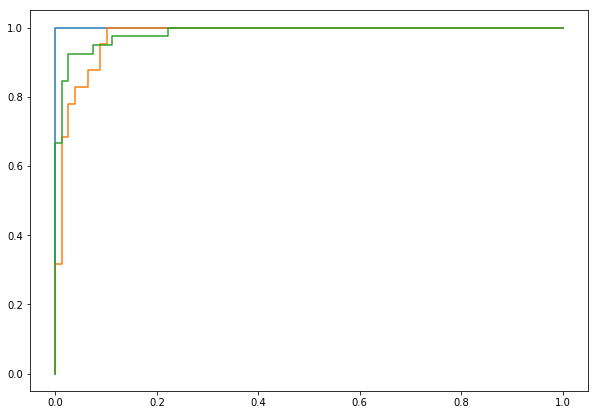

In [391]:
# pd.DataFrame(np.array([fpr_0,tpr_0]).T).set_index(0).iplot()
# pd.DataFrame(np.array([fpr_1,tpr_1]).T).set_index(0).iplot()
# pd.DataFrame(np.array([fpr_2,tpr_2]).T).set_index(0).iplot()
plt.figure(figsize=(10,7))
_ = plt.plot(fpr_0,tpr_0)
_ = plt.plot(fpr_1,tpr_1)
_ = plt.plot(fpr_2,tpr_2)


In [392]:
fpr_0, tpr_0, thr_0 = roc_curve(1*(y_train.idxmax(axis=1)=='target_setosa'),svm.predict_proba(X_train)[:,0])
fpr_1, tpr_1, thr_1 = roc_curve(1*(y_train.idxmax(axis=1)=='target_versicolor'),svm.predict_proba(X_train)[:,1])
fpr_2, tpr_2, thr_2 = roc_curve(1*(y_train.idxmax(axis=1)=='target_virginica'),svm.predict_proba(X_train)[:,2])

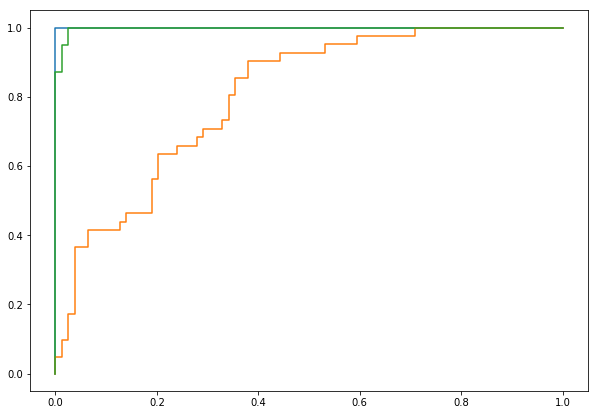

In [393]:
# pd.DataFrame(np.array([fpr_0,tpr_0]).T).set_index(0).iplot()
# pd.DataFrame(np.array([fpr_1,tpr_1]).T).set_index(0).iplot()
# pd.DataFrame(np.array([fpr_2,tpr_2]).T).set_index(0).iplot()
plt.figure(figsize=(10,7))
_ = plt.plot(fpr_0,tpr_0)
_ = plt.plot(fpr_1,tpr_1)
_ = plt.plot(fpr_2,tpr_2)